# Import the required modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

# number_of_samples determine how many samples from the attack and normal dataset should be read and used.

In [3]:
number_of_samples = 1200000

# Read data from attack and normal datasets.

In [4]:
data_attack = pd.read_csv('./dataset/dataset_attack.csv', nrows = number_of_samples)

In [5]:
len(data_attack)

1200000

In [6]:
data_normal = pd.read_csv('./dataset/dataset_normal.csv', nrows = number_of_samples)
# data_normal = pd.read_csv('./dataset/dataset_normal.csv')


In [7]:
len(data_normal)

1200000

In [8]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

# Drop unwanted columns

In [9]:
data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [10]:
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

In [11]:
X_normal= data_normal[features].values
X_attack= data_attack[features].values
Y_normal= data_normal['class']
Y_attack= data_attack['class']
X=np.concatenate((X_normal,X_attack))
Y=np.concatenate((Y_normal,Y_attack))

# Standardise the data

In [12]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

# the class field, replace value 'attack' with 0 and 'normal' with 1

In [13]:
for i in range(0,len(Y)):
    if Y[i] =="attack":
        Y[i]=0
    else:
        Y[i]=1
    

After feature transformation, we get a 𝑚×𝑛' matrix, where 𝑚 indicates the number of packets and 𝑛' indicates the number of new features after transformation. In order to learn patterns in both long and short term, we use a sliding window to separate continuous packets and reshape the data into a series of time windows with window size 𝑇. The label 𝑦 in each window illustrates the last packet. After reshaping, we have a three-dimensional matrix with shape (𝑚−𝑇 )×𝑇 ×𝑛'. Figure illustrates the workflow of feature extraction, transformation, and reshaping.
![dataset transformation](feature_extraction.png)
In this way, we change the features from conventional packet-based to window-based, by which we can learn network patterns from both previous (𝑇 −1) packets and current packet.

In [14]:
features = len(X[0])
samples = X.shape[0]
train_len = 25
input_len = samples - train_len + 1
I = np.zeros((input_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len):
        temp[j-i] = X[j]
    I[i] = temp

In [15]:
X.shape

(2400000, 25)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[24:2 * number_of_samples], test_size = 0.2)

The architecture used is 
![Model](model_brnn.png)

In [17]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [18]:
model = create_baseline()

In [19]:
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')

In [20]:
history = model.fit(X_train, Y_train, epochs = 20, validation_split=0.2, verbose = 1)

Epoch 1/20
48000/48000 [==============================] - 686s 14ms/step - loss: 0.1315 - accuracy: 0.9717 - val_loss: 0.1168 - val_accuracy: 0.9755
Epoch 2/20
48000/48000 [==============================] - 684s 14ms/step - loss: 0.1053 - accuracy: 0.9772 - val_loss: 0.0985 - val_accuracy: 0.9790
Epoch 3/20
48000/48000 [==============================] - 676s 14ms/step - loss: 0.0975 - accuracy: 0.9788 - val_loss: 0.0957 - val_accuracy: 0.9777
Epoch 4/20
48000/48000 [==============================] - 674s 14ms/step - loss: 0.0920 - accuracy: 0.9801 - val_loss: 0.0886 - val_accuracy: 0.9805
Epoch 5/20
48000/48000 [==============================] - 689s 14ms/step - loss: 0.0891 - accuracy: 0.9808 - val_loss: 0.0811 - val_accuracy: 0.9820
Epoch 6/20
48000/48000 [==============================] - 684s 14ms/step - loss: 0.0860 - accuracy: 0.9816 - val_loss: 0.0810 - val_accuracy: 0.9824
Epoch 7/20
48000/48000 [==============================] - 667s 14ms/step - loss: 0.0838 - accuracy: 0.9822

Obtained plot of accuracy

![plot of accuracy](BRNN_Model_Accuracy.png)

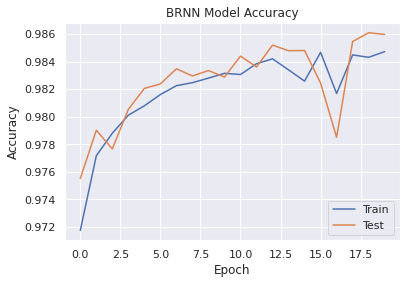

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

Plot of loss
![plot of loss](BRNN_Model_Loss.png)

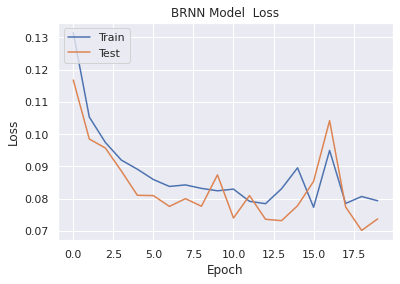

In [22]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()


In [23]:
predict = model.predict(X_test, verbose=1)

15000/15000 [==============================] - 66s 4ms/step


#  Calculate True positive,True negetive,False positive and False negetive values. Create Heatmap.

In [24]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
    if predictn[i]==1 and Y_testn[i]==1:
        tp+=1
    elif predictn[i]==0 and Y_testn[i]==0:
        tn+=1
    elif predictn[i]==0 and Y_testn[i]==1:
        fp+=1
    elif predictn[i]==1 and Y_testn[i]==0:
        fn+=1


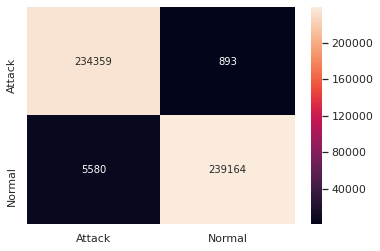

In [25]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

# Save details 

In [26]:
figure = ax.get_figure()    
figure.savefig('confusion_matrix_BRNN.png', dpi=400)

In [27]:
model.save('brnn_model.h5')

In [28]:
X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')

In [29]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.65%
